# Link between free space and 3-points efficiency

After modelling both model of space occupation and comparing them, we focus on the correlation between space occupation and 3-point performance. To do so, we browse all the games we have, we track when there are 3-point shots and then memorize the evolution of pressure on the shooter 3 seconds before he shots. The algorithm is not presented here, but is available as a python file : track_shoot.py.

Here we extract the informations we want from the data we collected. 

## Data import
-----

The shots are memorized in two csv files : df_plot_mean and df_shots. They contain the same information but aren't structured in the same way (df_plot_mean's structure let us plot averaged evolution). They are composed of the following columns :
* D : evolution of the shooter's *free space* ($\delta_{space}^*$ distance to the closest defender) 3 seconds before the shot. 
* T : It the same but *free space* is calculated as the time (in second) needed by the closest defender to join the position of the shooter ($\delta_{time}^*$). 
* Time_to_shoot : corresponds to the time between the reception of the ball and the shot. It is negative : -2 means that the shooter kept the ball 2 seconds before shooting.
* Time : corresponds to time values linked to free space evolution.
* player_id : a list which contains shooters' ID.
* x_shot,y_shot : position of the player at the release.
* x_ball, y_ball, z_ball : ball's trajectory.
* quarter,clock,Match_id
* Shot_type : type of shots (catch-and-shoot or pull-up)


In [1]:
import pandas as pd
import ast

df_plot_mean=pd.read_csv('data/df_plot_mean.csv',index_col=[0])
df_shots=pd.read_csv('data/df_shots.csv',index_col=[0],converters={1:ast.literal_eval,2:ast.literal_eval,3:ast.literal_eval,7:ast.literal_eval,8:ast.literal_eval,9:ast.literal_eval})
df_stats=pd.read_csv('data/df_stats.csv',index_col=[0])

/Users/gabin/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [2]:
print('number of shots:',len(df_shots))

number of shots: 26559


## *Free space* evolution before a 3-point shot
------

### Plot all shots

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

(0, 30)

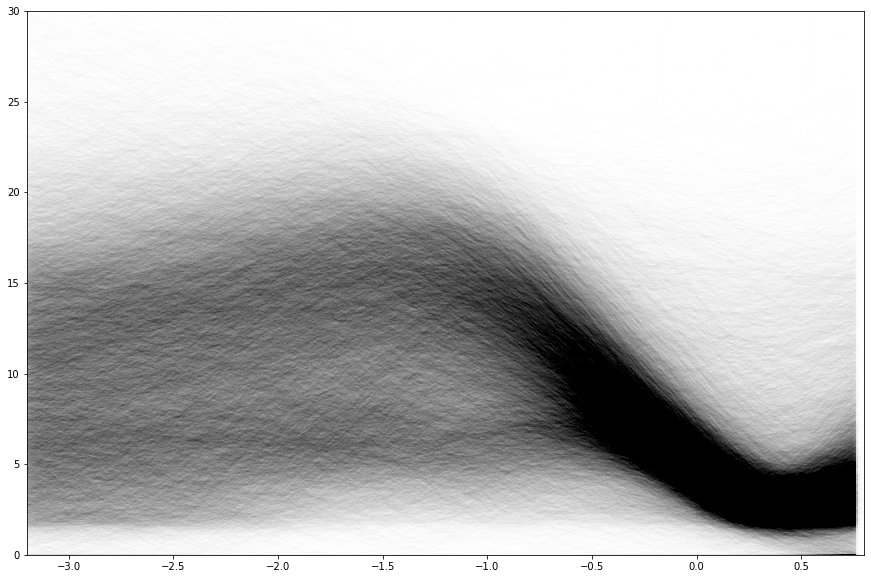

In [39]:
fig=plt.figure(figsize=(15,10))
for row in df_shots.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    plt.plot(Time,D,'k-',alpha=0.005)
plt.xlim((-3.2,0.8))
plt.ylim((0,30))

### Mean evolution

First we compute a function to plot the evolution of *free space* averaged on all the shots. Let's note that we round the values of time with a precision of 0.01 second. Yet the precision of position data is only 0.04 seconds. 

Let's note that we delet some shots because the values of time are wrong : the clock stops but the evolution continue to be captured therefore, if we don't do that, we have false values for a certain value of time.

In [11]:
def averaged_evolution(df,sd=None,hue=None,palette=['blue'],style=None,fontsize='medium',size=None):
    
    ## rename columns to have good labels ##
    df2=df.rename(columns={"Time": "time [s]",'D':r'$<\delta_{d}^*(t)$> [feet]','T':r'$<\delta_{t}^*(t)$> [s]'})
    
    ### plot ###
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{d}^*(t)$> [feet]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize=fontsize)
    plt.show()
    plt.clf()
   
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{t}^*(t)$> [s]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize=fontsize)
    plt.show()
    plt.clf()

No handles with labels found to put in legend.


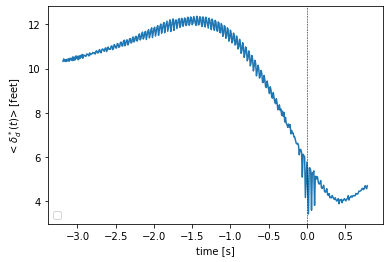

No handles with labels found to put in legend.


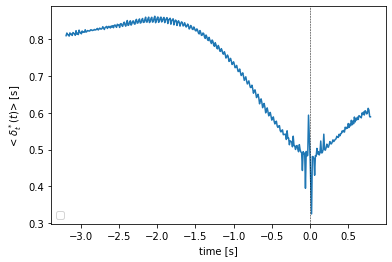

<Figure size 432x288 with 0 Axes>

In [5]:
averaged_evolution(df_plot_mean)

We see that there is some noise. To calculate the plot sns.lineplot take each value of time and make a mean over all the pressure value associated. If we count the number of pressure values per time value we can see that there isn't an equilibrium as there are more of multiple of 0.04 :

In [21]:
print('count',df.groupby('Time').count())

count            D      T  Time_to_shoot  Shot result  player_id  x_ball  y_ball  \
Time                                                                         
-3.19   3445   3445           3445         3445       3445    3445    3445   
-3.18   2907   2907           2907         2907       2907    2907    2907   
-3.17   4156   4156           4156         4156       4156    4156    4156   
-3.16  14636  14636          14636        14636      14636   14636   14636   
-3.15   3710   3710           3710         3710       3710    3710    3710   
...      ...    ...            ...          ...        ...     ...     ...   
 0.75   2421   2421           2421         2421       2421    2421    2421   
 0.76  19569  19569          19569        19569      19569   19569   19569   
 0.77   3726   3726           3726         3726       3726    3726    3726   
 0.78    524    524            524          524        524     524     524   
 0.79    169    169            169          169        169

Our aim is to make mean for each value of time over the 26325 shots. To do so, we will aggregate values around multiple of 0.04 seconds with the following function :

In [100]:
def aggregating_04(row):
    number=row['Time']
    q=number//0.04
    if abs(round((q*0.04-number),2))<=0.02:
        return(q*0.04)
    else :
        return((q+1)*0.04)

In [ ]:
df_plot_mean['Time']=df_plot_mean.apply(aggregating_04,axis=1)

No handles with labels found to put in legend.


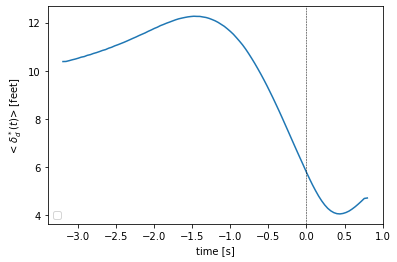

No handles with labels found to put in legend.


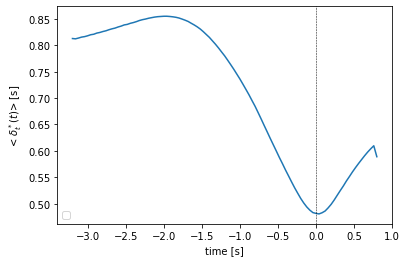

<Figure size 432x288 with 0 Axes>

In [13]:
averaged_evolution(df_plot_mean)

The result is better here. Now let's see if we plot the standard deviation :

No handles with labels found to put in legend.


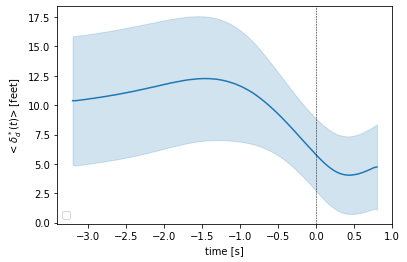

No handles with labels found to put in legend.


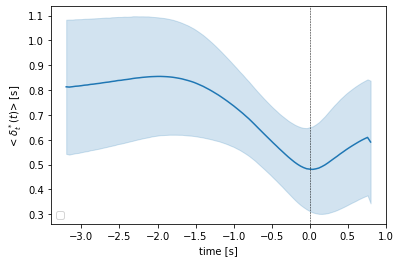

<Figure size 432x288 with 0 Axes>

In [9]:
averaged_evolution(df_plot_mean,sd='sd')

### Different types of shots

We distinguish two types of shots :
* catch-and-shoot shot : when a player immediately shot after receiving the ball (2 seconds after)
* pull-up shot : when a player shot after dribbling

In fact some shots can be in neither category : wait more than two seconds without dribbling. But we admit that this is only a small part of shots. Therefore to distinguish both types we look at the value TIME_TO_SHOOT.

We found that there were 78% of catch-and-shoot shots. Yet our games are from 2013 to 2016, according to https://www.thespax.com/nba/three-point-shooting-part-i-the-dying-catch-and-shoot-shot/, there were about 75% of catch-and-shoot shots. Our value is closed to the reality.

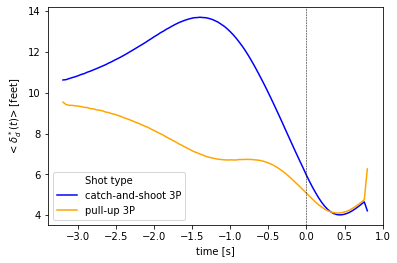

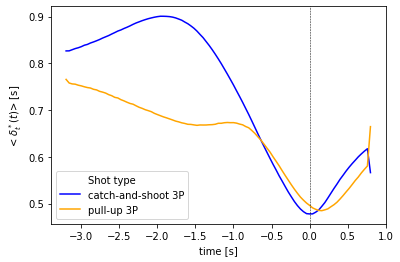

<Figure size 432x288 with 0 Axes>

In [12]:
averaged_evolution(df_plot_mean,palette=['blue','orange'],hue='Shot_type')

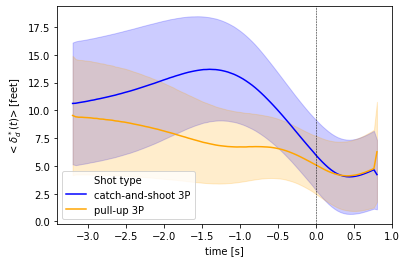

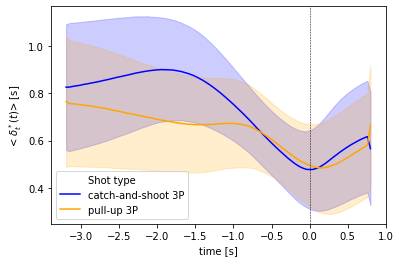

<Figure size 432x288 with 0 Axes>

In [13]:
averaged_evolution(df_plot_mean,palette=['blue','orange'],hue='Shot type',sd='sd')

### Difference between success and miss

We want to know if the pressure exerced on a player has an influence on his 3-point performance.

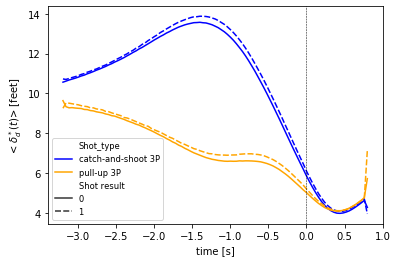

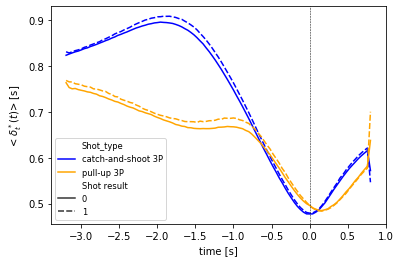

<Figure size 432x288 with 0 Axes>

In [17]:
averaged_evolution(df_plot_mean,palette=['blue','orange'],hue='Shot_type',style='Shot result',fontsize='small')

### Curry's case

No handles with labels found to put in legend.


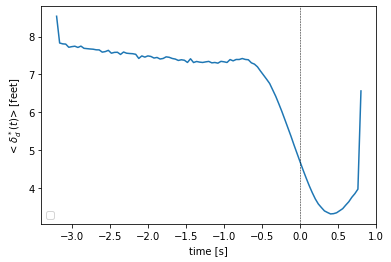

No handles with labels found to put in legend.


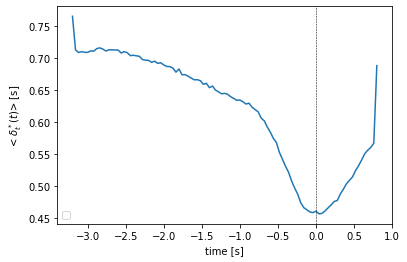

<Figure size 432x288 with 0 Axes>

In [18]:
df_curry_mean=df_plot_mean.query('player_id==201939').copy()
averaged_evolution(df_curry_mean)

No handles with labels found to put in legend.


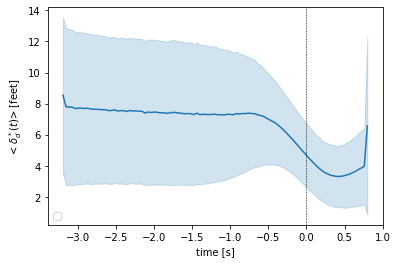

No handles with labels found to put in legend.


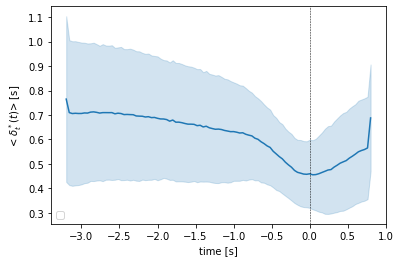

<Figure size 432x288 with 0 Axes>

In [18]:
averaged_evolution(df_curry_mean,sd='sd')

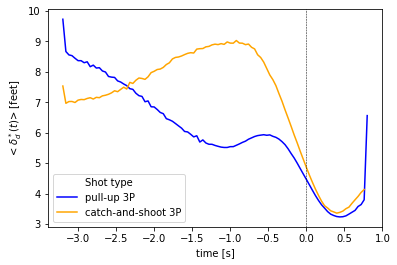

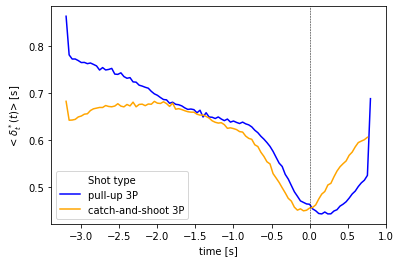

<Figure size 432x288 with 0 Axes>

In [19]:
averaged_evolution(df_curry_mean,palette=['blue','orange'],hue='Shot_type')

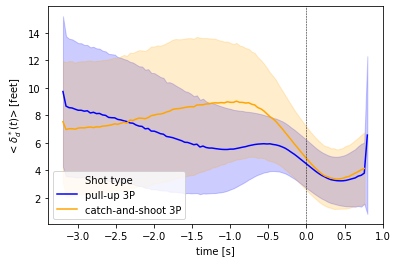

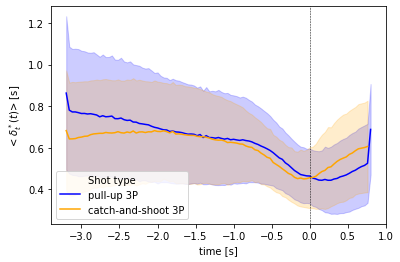

<Figure size 432x288 with 0 Axes>

In [20]:
averaged_evolution(df_curry,palette=['blue','orange'],hue='Shot_type',sd='sd')

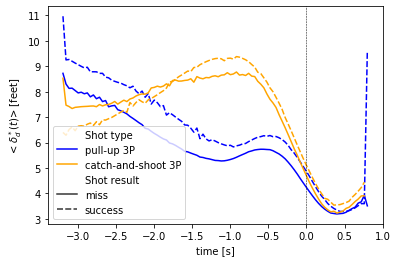

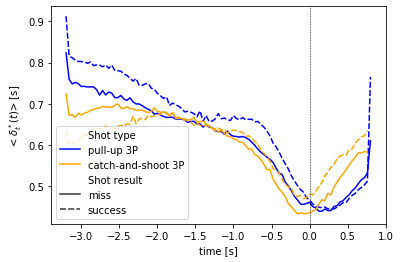

<Figure size 432x288 with 0 Axes>

In [21]:
averaged_evolution(df_curry_mean,palette=['blue','orange'],hue='Shot_type',style='Shot result')

### Compare Curry to global behaviour

In [30]:
def averaged_evolution_two_df(df,df_curry,sd=None,hue=None,palette=['blue'],style=None,size=None):
    
    ## rename columns to have good labels ##
    df2=pd.concat([df,df_curry],ignore_index=True)
    players=['all' for k in range(len(df))]+['Curry' for k in range(len(df_curry))]
    df2['Player']=players
    df2=df2.rename(columns={"Time": "time [s]",'D':r'$<\delta_{d}^*(t)$> [feet]','T':r'$<\delta_{t}^*(t)$> [s]'})
    
    ### plot ###
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{d}^*(t)$> [feet]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    plt.show()
    plt.clf()
   
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{t}^*(t)$> [s]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    #plt.savefig('Comparison_curry_t',dpi=72)
    plt.show()
    plt.clf()

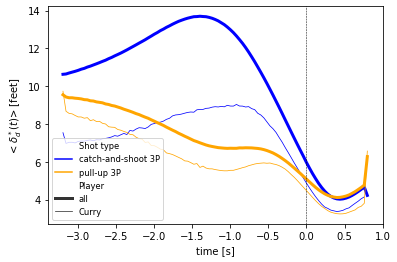

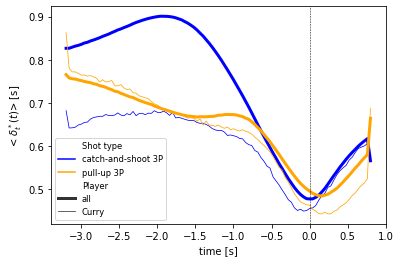

<Figure size 432x288 with 0 Axes>

In [43]:
averaged_evolution_two_df(df_plot_mean,df_curry_mean,sd=None,hue='Shot type',palette=['blue','orange'],style=None,size='Player')

## Curry superimposed shots

(0, 2)

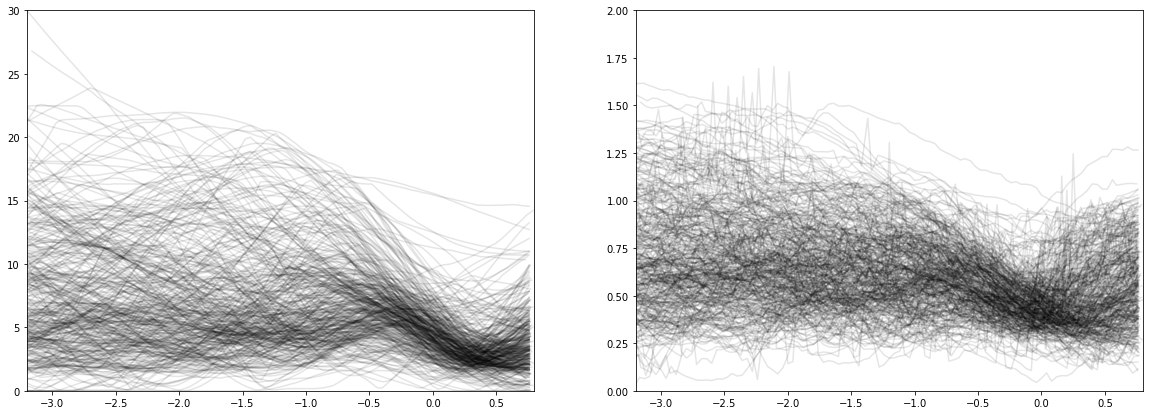

In [37]:
df_curry=df_shots.query('player_id==201939').copy()

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,7))
k=0
for row in df_curry.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax1.plot(Time,D,'k-',alpha=0.1)
    ax2.plot(Time,T,'k-',alpha=0.1)
    k+=1
    
    
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,2))

(0, 30)

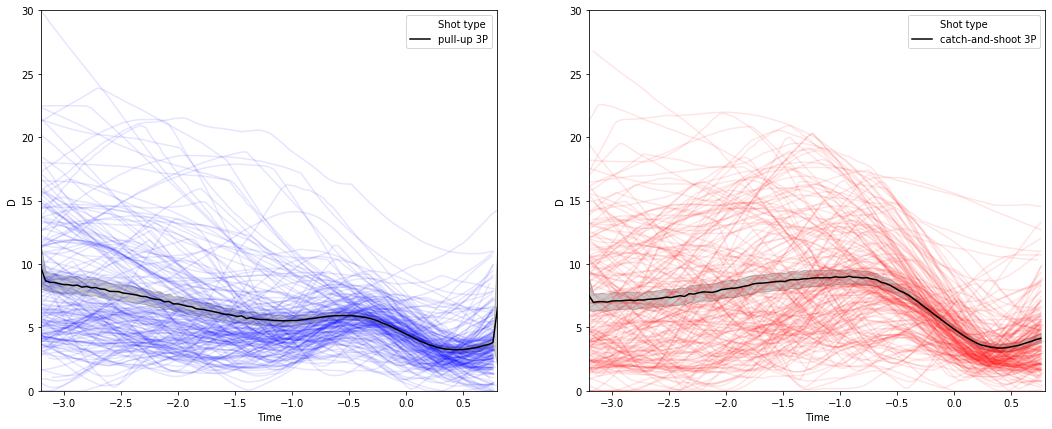

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,7))
df_curry_pull_up=df_shots.query('player_id==201939 and Shot_type=="pull-up 3P"').copy()
df_curry_catch=df_shots.query('player_id==201939 and Shot_type=="catch-and-shoot 3P"').copy()
for row in df_curry_pull_up.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax1.plot(Time,D,'b-',alpha=0.1)
    #ax2.plot(Time,T,'b-',alpha=0.1)
    k+=1
    
for row in df_curry_catch.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax2.plot(Time,D,'r-',alpha=0.1)
    #ax2.plot(Time,T,'r-',alpha=0.1)

sns.lineplot(x="Time", y='D', data=df_curry_mean[df_curry_mean['Shot_type']=="pull-up 3P"],hue='Shot_type',palette=['black'],ax=ax1,size_order=[60])
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_curry_mean[df_curry_mean['Shot_type']=="catch-and-shoot 3P"],hue='Shot_type',palette=['black'],ax=ax2,size_order=[60])
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,30))

029 1 163.22 201939


(0, 2)

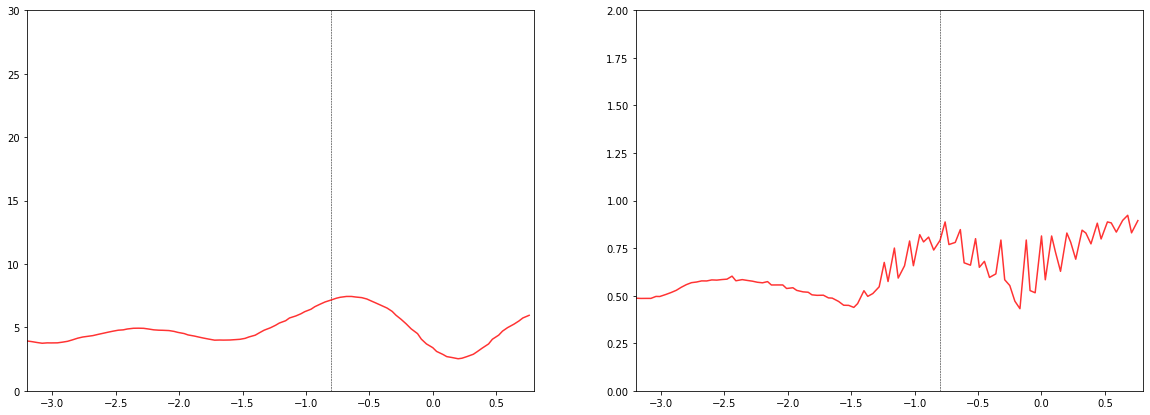

In [92]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,7))

#for row in df_curry_pull_up.iloc[:3].itertuples():
#    Time=getattr(row,'Time')
#    D=getattr(row,'D')
#    T=getattr(row,'T')
#   tts=getattr(row,'Time_to_shoot')[0]
#    ax1.axvline(tts, color='b',linestyle="dashed",lw=0.5)
#    ax2.axvline(tts, color='b',linestyle="dashed",lw=0.5)
#    ax1.plot(Time,D,'b-',alpha=0.8)
#    ax2.plot(Time,T,'b-',alpha=0.8)
    
for row in df_curry_catch.iloc[100:101].itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    tts=getattr(row,'Time_to_shoot')[0]
    print(getattr(row,'Match_id'),getattr(row,'quarter'),getattr(row,'clock'),getattr(row,'player_id'))
    ax1.axvline(tts, color='black',linestyle="dashed",lw=0.5)
    ax2.axvline(tts, color='black',linestyle="dashed",lw=0.5)
    ax1.plot(Time,D,'r-',alpha=0.8)
    ax2.plot(Time,T,'r-',alpha=0.8)
    
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,2))

### Comparing two players with high percentage

number of shots Curry: 390
percentage of CandS Curry: 0.5153846153846153
number of shots Other: 285
percentage of CandS Other: 0.8842105263157894


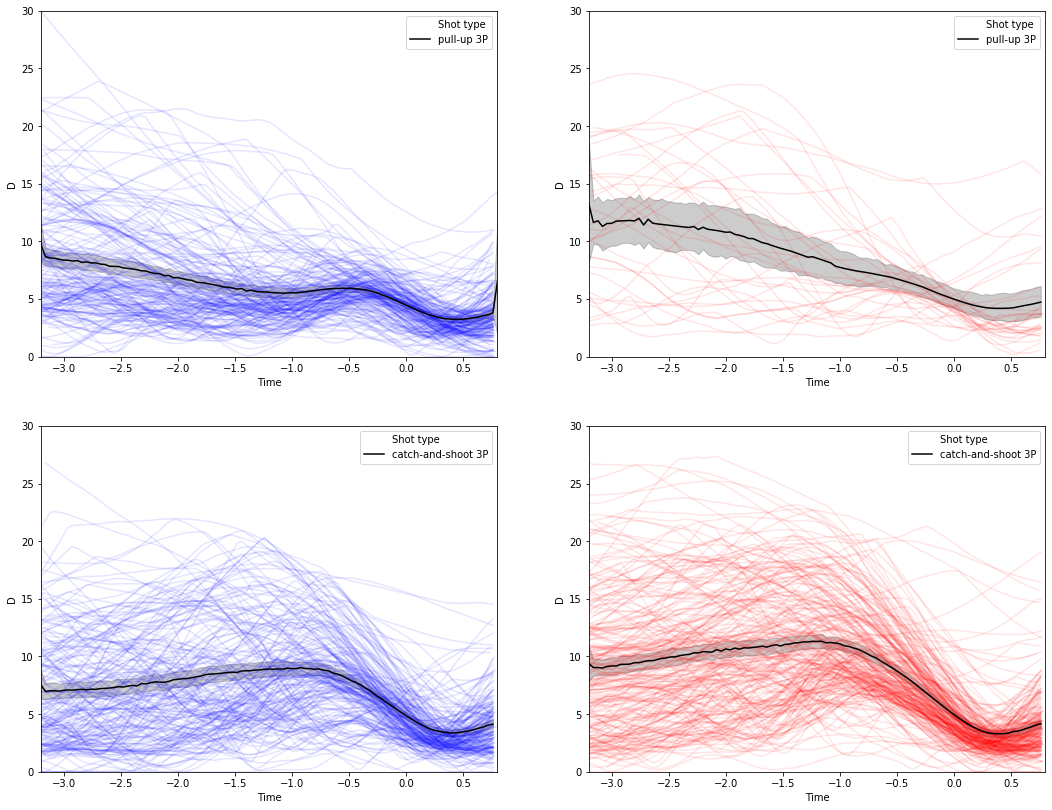

In [74]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(18,14))
df_other_mean=df.query('player_id==202691').copy()

df_curry_pull_up=df_shots.query('player_id==201939 and Shot_type=="pull-up 3P"').copy()
df_other_pull_up=df_shots.query('player_id==202691 and Shot_type=="pull-up 3P"').copy()
df_curry_catch=df_shots.query('player_id==201939 and Shot_type=="catch-and-shoot 3P"').copy()
df_other_catch=df_shots.query('player_id==202691 and Shot_type=="catch-and-shoot 3P"').copy()

print('number of shots Curry:',len(df_curry_pull_up)+len(df_curry_catch))
print('percentage of CandS Curry:',len(df_curry_catch)/(len(df_curry_catch)+len(df_curry_pull_up)))
print('number of shots Other:',len(df_other_pull_up)+len(df_other_catch))
print('percentage of CandS Other:',len(df_other_catch)/(len(df_other_catch)+len(df_other_pull_up)))

for row in df_curry_pull_up.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax1.plot(Time,D,'b-',alpha=0.1)
    #ax3.plot(Time,T,'b-',alpha=0.1)

for row in df_curry_catch.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax3.plot(Time,D,'b-',alpha=0.1)
    #ax3.plot(Time,T,'b-',alpha=0.1)
    
for row in df_other_pull_up.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax2.plot(Time,D,'r-',alpha=0.1)
    #ax2.plot(Time,T,'r-',alpha=0.1)
    
for row in df_other_catch.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax4.plot(Time,D,'r-',alpha=0.1)
    
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_curry_mean[df_curry_mean['Shot type']=="pull-up 3P"],hue='Shot type',palette=['black'],ax=ax1,size_order=[60])
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_other_mean[df_other_mean['Shot type']=="pull-up 3P"],hue='Shot type',palette=['black'],ax=ax2,size_order=[60])
ax3.set_xlim((-3.2,0.8))
ax3.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_curry_mean[df_curry_mean['Shot type']=="catch-and-shoot 3P"],hue='Shot type',palette=['black'],ax=ax3,size_order=[60])
ax4.set_xlim((-3.2,0.8))
ax4.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_other_mean[df_other_mean['Shot type']=="catch-and-shoot 3P"],hue='Shot type',palette=['black'],ax=ax4,size_order=[60])

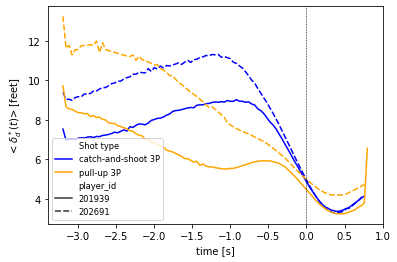

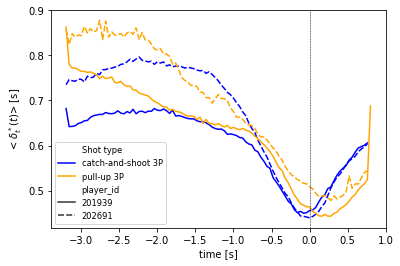

<Figure size 432x288 with 0 Axes>

In [75]:
df_other_mean=df.query('player_id==202691').copy()
averaged_evolution_two_players(df_other_mean,df_curry_mean,sd=None,hue='Shot type',palette=['blue','orange'],style='player_id')

### Comparing two players : one with high and the other with low percentage

number of shots Curry: 390
percentage of CandS Curry: 0.5153846153846153
number of shots Other: 56
percentage of CandS Other: 0.9642857142857143


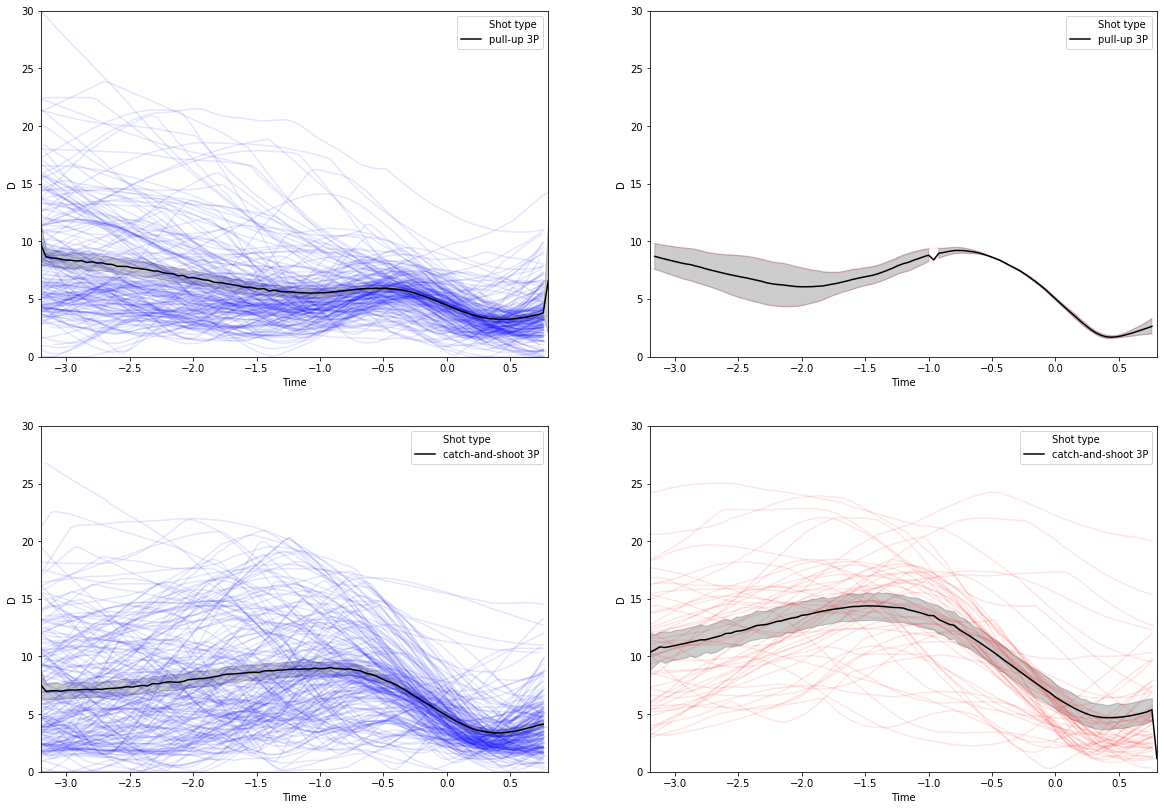

In [76]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(20,14))
df_other_mean=df.query('player_id==202323').copy()

df_curry_pull_up=df_shots.query('player_id==201939 and Shot_type=="pull-up 3P"').copy()
df_other_pull_up=df_shots.query('player_id==202323 and Shot_type=="pull-up 3P"').copy()
df_curry_catch=df_shots.query('player_id==201939 and Shot_type=="catch-and-shoot 3P"').copy()
df_other_catch=df_shots.query('player_id==202323 and Shot_type=="catch-and-shoot 3P"').copy()

print('number of shots Curry:',len(df_curry_pull_up)+len(df_curry_catch))
print('percentage of CandS Curry:',len(df_curry_catch)/(len(df_curry_catch)+len(df_curry_pull_up)))
print('number of shots Other:',len(df_other_pull_up)+len(df_other_catch))
print('percentage of CandS Other:',len(df_other_catch)/(len(df_other_catch)+len(df_other_pull_up)))

for row in df_curry_pull_up.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax1.plot(Time,D,'b-',alpha=0.1)
    #ax3.plot(Time,T,'b-',alpha=0.1)

for row in df_curry_catch.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax3.plot(Time,D,'b-',alpha=0.1)
    #ax3.plot(Time,T,'b-',alpha=0.1)
    
for row in df_other_pull_up.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax2.plot(Time,D,'r-',alpha=0.1)
    #ax2.plot(Time,T,'r-',alpha=0.1)
    
for row in df_other_catch.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax4.plot(Time,D,'r-',alpha=0.1)
    
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_curry_mean[df_curry_mean['Shot type']=="pull-up 3P"],hue='Shot type',palette=['black'],ax=ax1,size_order=[60])
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_other_mean[df_other_mean['Shot type']=="pull-up 3P"],hue='Shot type',palette=['black'],ax=ax2,size_order=[60])
ax3.set_xlim((-3.2,0.8))
ax3.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_curry_mean[df_curry_mean['Shot type']=="catch-and-shoot 3P"],hue='Shot type',palette=['black'],ax=ax3,size_order=[60])
ax4.set_xlim((-3.2,0.8))
ax4.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_other_mean[df_other_mean['Shot type']=="catch-and-shoot 3P"],hue='Shot type',palette=['black'],ax=ax4,size_order=[60])

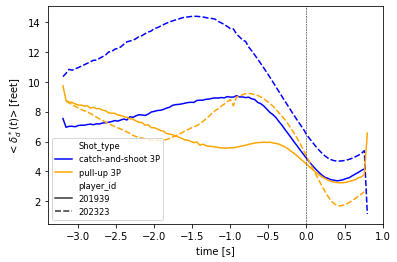

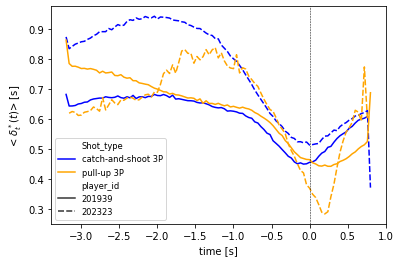

<Figure size 432x288 with 0 Axes>

In [20]:
df_other_mean=df_plot_mean.query('player_id==202323').copy()

def averaged_evolution_two_players(df_player1,df_player2,sd=None,hue=None,palette=['blue'],style=None,size=None):
    
    ## rename columns to have good labels ##
    df=pd.concat([df_player1,df_player2],ignore_index=True)
    df=df.rename(columns={"Time": "time [s]",'D':r'$<\delta_{d}^*(t)$> [feet]','T':r'$<\delta_{t}^*(t)$> [s]'})

    ### plot ###
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{d}^*(t)$> [feet]', data=df,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    plt.show()
    plt.clf()
   
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{t}^*(t)$> [s]', data=df,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    #plt.savefig('Comparison_curry_t',dpi=72)
    plt.show()
    plt.clf()
averaged_evolution_two_players(df_other_mean,df_curry_mean,sd=None,hue='Shot_type',palette=['blue','orange'],style='player_id')

### Link between time to shoot and free space at ball's reception

In [456]:
def d_reception(row):
    "Calculate distance of the closest player at ball reception"
    D=row['D']
    Time=row['Time']
    TTS=row['Time_to_shoot']
    if TTS<-3:
        return(D[0])
    i=0
    while  i<len(Time) and round(Time[i],2)!=round(TTS,2):
        i+=1
    if i>=len(D):
        return D[0]
    return D[i]

def t_reception(row):
    "Calculate distance of the closest player at ball reception"
    T=row['T']
    Time=row['Time']
    TTS=row['Time_to_shoot']
    if TTS<-3:
        return(T[0])
    i=0
    while  i<len(Time) and round(Time[i],2)!=round(TTS,2):
        i+=1
    if i>=len(T):
        return T[0]
    return T[i]

df_shots['d_reception']=df_shots.apply(d_reception,axis=1)
df_shots['t_reception']=df_shots.apply(t_reception,axis=1)

/Users/gabin/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


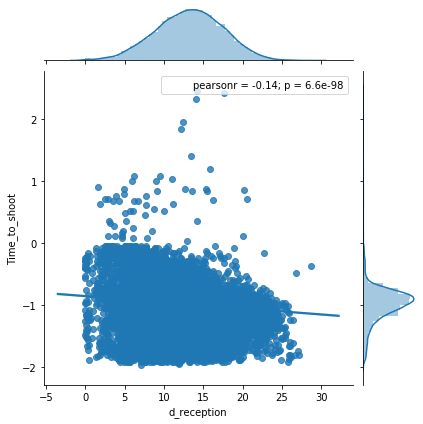

In [462]:
#fig,ax=plt.subplots(1,1,figsize=(15,10))

#x1=np.array(df_shots.query('Shot_type=="catch-and-shoot 3P"')['d_reception'].tolist())
#y1=np.array(df_shots.query('Shot_type=="catch-and-shoot 3P"')['Time_to_shoot'].tolist())
#x1 = x1.reshape(len(x1), 1)
#y1 = y1.reshape(len(x1), 1)
#regr1 = linear_model.LinearRegression()
#regr1.fit(x1, y1)
#R1=regr1.score(x1,y1)
#ax.plot(x1, regr1.predict(x1), color='blue')

#df_shots.query('Shot_type=="catch-and-shoot 3P"').plot(x='d_reception',y='Time_to_shoot',alpha=0.08,kind='scatter',ax=ax)

g=sns.jointplot(x='d_reception',y='Time_to_shoot', data=df_shots.query('Shot_type=="catch-and-shoot 3P" and d_reception<30'),kind='reg')
g.annotate(stats.pearsonr)

(0, 25)

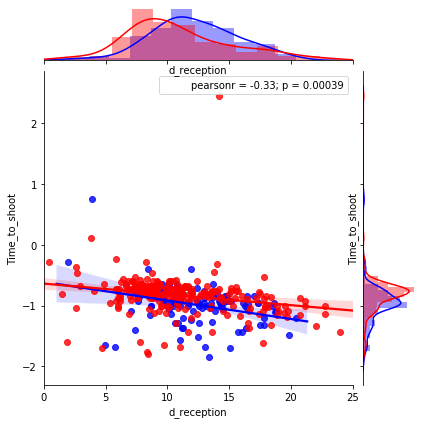

In [464]:
from sklearn import linear_model
#fig,ax=plt.subplots(1,1,figsize=(15,10))
#x1=np.array(df_shots.query('player_id==202691 and Shot_type=="catch-and-shoot 3P"')['d_reception'].tolist())
#y1=np.array(df_shots.query('player_id==202691 and Shot_type=="catch-and-shoot 3P"')['Time_to_shoot'].tolist())
#x1 = x1.reshape(len(x1), 1)
#y1 = y1.reshape(len(x1), 1)
#regr1 = linear_model.LinearRegression()
#regr1.fit(x1, y1)
#R1=regr1.score(x1,y1)
#ax.plot(x1, regr1.predict(x1), color='blue')

#x2=np.array(df_shots.query('player_id==202331 and Shot_type=="catch-and-shoot 3P"')['d_reception'].tolist())
#y2=np.array(df_shots.query('player_id==202331 and Shot_type=="catch-and-shoot 3P"')['Time_to_shoot'].tolist())
#x2 = x2.reshape(len(x2), 1)
#y2 = y2.reshape(len(x2), 1)
#regr2 = linear_model.LinearRegression()
#regr2.fit(x2, y2)
#R2=regr2.score(x2,y2)
#ax.plot(x2, regr2.predict(x2), color='red')

g = sns.JointGrid(x='d_reception',y='Time_to_shoot', data=df_shots.query('player_id==202695 and Shot_type=="catch-and-shoot 3P"'))
g.plot_joint(sns.regplot,color='blue')
g.plot_marginals(sns.distplot,color='blue')
g.annotate(stats.pearsonr)
g.x=df_shots.query('player_id==202691 and Shot_type=="catch-and-shoot 3P"')['d_reception']
g.y=df_shots.query('player_id==202691 and Shot_type=="catch-and-shoot 3P"')['Time_to_shoot']
g.plot_joint(sns.regplot,color='red')
g.plot_marginals(sns.distplot,color='red')
#g.annotate(stats.pearsonr)
g.ax_joint.set_xlim((0,25))
#df_shots.query('player_id==202691 and Shot_type=="catch-and-shoot 3P"').plot(x='d_reception',y='Time_to_shoot',alpha=0.7,kind='scatter',ax=ax)
#df_shots.query('player_id==202331 and Shot_type=="catch-and-shoot 3P"').plot(x='d_reception',y='Time_to_shoot',alpha=0.7,kind='scatter',ax=ax,color='red')

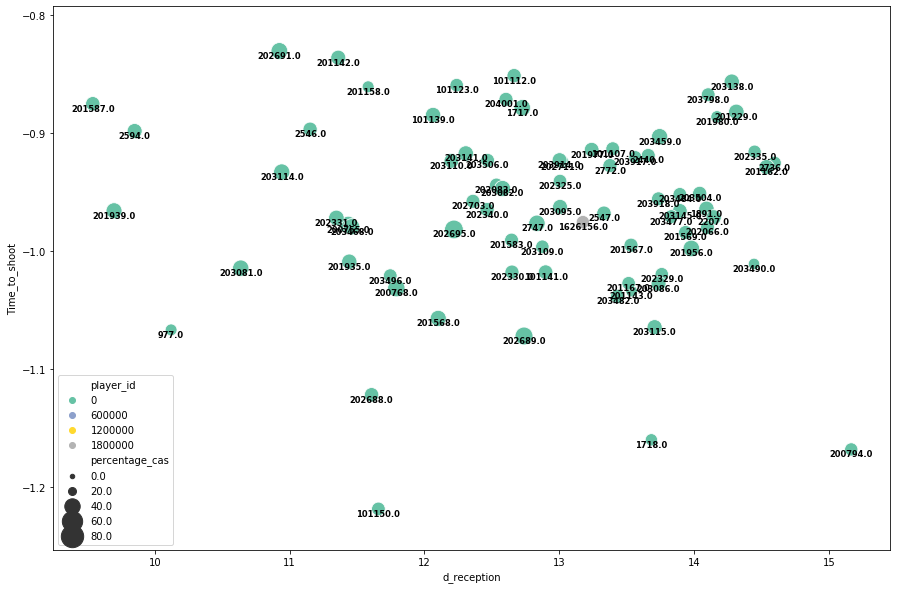

In [457]:
fig,ax=plt.subplots(1,1,figsize=(15,10))

players=df_stats.query('total_cas>100').index
df_shots_mean=df_shots.query('player_id in @players and Shot_type=="catch-and-shoot 3P"')[['player_id','Time_to_shoot','d_reception','t_reception']].groupby('player_id').mean()

df_plot_shots=df_shots_mean.join(df_stats.query('total_cas>100'))
df_plot_shots['player_id']=df_shots_mean.index
#df_shots_mean.plot(x='d_reception',y='Time_to_shoot',kind='scatter',ax=ax)
p=sns.scatterplot(x='d_reception',y='Time_to_shoot',palette="Set2", data=df_plot_shots,hue='player_id',ax=ax,size='percentage_cas',sizes=(20, 500),size_norm=(15,70))
for line in range(df_plot_shots.shape[0]):
    p.text(df_plot_shots.iloc[line]['d_reception'], df_plot_shots.iloc[line]['Time_to_shoot'], df_plot_shots.iloc[line]['player_id'], horizontalalignment='center', verticalalignment='top',size='small', color='black', weight='semibold')

In [91]:
df_shots_mean.loc[1495]

Time_to_shoot   -1.064667
d_reception      9.680607
t_reception      0.765056
Name: 1495, dtype: float64

In [248]:
print(R1,R2)

0.05403172150999214 0.027882178239838407


## Study of ball trajectory
-----

https://towardsdatascience.com/tensorflow-reflective-tape-why-im-bad-at-basketball-a30a923332de
https://www.desmos.com/calculator/gjnco6mzjo

In [6]:
df_traj=pd.read_csv('data/df_trajectories.csv',index_col=[0],converters={1:ast.literal_eval,2:ast.literal_eval,3:ast.literal_eval,7:ast.literal_eval,8:ast.literal_eval,9:ast.literal_eval})

In [268]:
def distance_to_basket(row): 
    z_ball=row['z_ball']
    x_ball=row['x_ball']
    y_ball=row['y_ball']
    
    if x_ball[-1]>94//2:
        basket_pos=[94-5.25,25]
    else :
        basket_pos=[5.25,25]
    
    d_basket=[]
    for k in range(len(x_ball)):
        d_basket.append(-np.sqrt((x_ball[k]-basket_pos[0])**2+(y_ball[k]-basket_pos[1])**2))
    
    return(d_basket)

def shoot_traj(df_traj,i):

    z_ball=df_traj.query('shot_id==@i')['z_ball'].iloc[0]
    d_basket=df_traj.query('shot_id==@i')['d_basket'].iloc[0]
        
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    ax1.plot(df_traj.query('shot_id==@i')['Time'].iloc[0],z_ball)
    ax2.plot(df_traj.query('shot_id==@i')['d_basket'].iloc[0],z_ball)
    #plt.axvline(-22, color='black',linestyle="dashed",lw=0.5)
    #plt.axvline(-23.75, color='black',linestyle="dashed",lw=0.5)
    #ax1.set_ylim((0,100))
    plt.show()

#df_traj['d_basket']=df_traj.apply(distance_to_basket,axis=1) 
#df_shots['d_basket']=df_shots.apply(distance_to_basket,axis=1) 

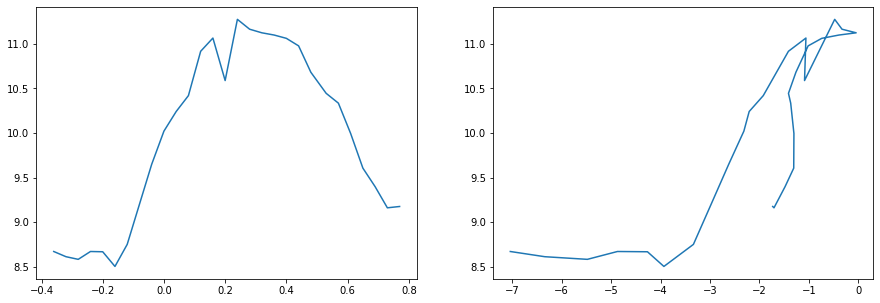

In [345]:
shoot_traj(df_shots,402)

In [292]:
def z_angle(row):
    z_ball=row['z_ball']
    d_basket=row['d_basket']
    angle=[]
    for k in range(len(d_basket)-1):
        z1=z_ball[k]
        z2=z_ball[k+1]
        d1=d_basket[k]
        d2=d_basket[k+1]
        if (d2-d1)<=0:
            angle.append(np.degrees(np.arctan((z2-z1)/(d2-d1)))+180)
        else :
            if (z2-z1)<=0:
                angle.append(np.degrees(np.arctan((z2-z1)/(d2-d1)))+360)
            else:
                angle.append(np.degrees(np.arctan((z2-z1)/(d2-d1))))
    return(angle)

    
#df_traj['angle']=df_traj.apply(z_angle,axis=1)  
df_shots['angle']=df_shots.apply(z_angle,axis=1)  

/Users/gabin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
def release_time(row):
    Time=row['Time']
    angle=df_traj['angle']

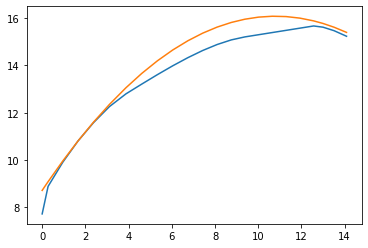

In [240]:
def traj(x, velocity, angle, h, g=9.8):
    angle = np.deg2rad(angle)
    lhs = x * np.tan(angle)
    rhs_top = g * x ** 2
    rhs_bottom = (2*(velocity)**2) * (np.cos(angle)**2)
    return h+lhs - (rhs_top / rhs_bottom)

n=75
s=1
#a=df_traj_bis.iloc[15438]['angle'][n]
a=45
v=(df_shots.iloc[s]['z_ball'][n+1]-df_shots.iloc[s]['z_ball'][n])/abs(df_shots.iloc[s]['Time'][n+1]-df_shots.iloc[s]['Time'][n])
z1=df_shots.iloc[s]['z_ball'][n:]
#z2=running_mean(z1,4)
x1=np.array(df_shots.iloc[s]['d_basket'][n:])
x1=x1-x1[0]
plt.plot(x1,z1)
#plt.plot(x[:len(z2)],z2)
plt.plot(x1,traj(x1,14.9,53.8,8.71))

406
90 13.17209
90 13.17209
89 12.93329
88 12.92917
87 12.70606
86 12.48232
85 12.29262
84 12.02587
83 11.70262
82 11.32003
81 10.8752
80 10.36527
79 9.78738
78 9.33121
77 8.75718
77
23.848716828745687
21.97605403533036
20


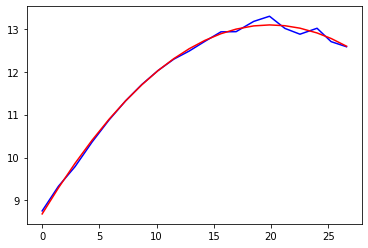

In [376]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np


def test(df_traj):
    n=0
    s=11
    print(len(df_traj.query('precise_angle<30')))
    Time=df_traj.query('precise_angle<30').iloc[s]['Time']
    time_end=-1

    z_ball=df_traj.query('precise_angle<30').iloc[s]['z_ball']
    angle=df_traj.query('precise_angle<30').iloc[s]['angle']
    time_start=z_ball.index(max(z_ball))
    time_start-=1
    print(time_start,z_ball[time_start])
    while z_ball[time_start]>8.2 and (30<angle[time_start] or angle[time_start]<70):
        print(time_start,z_ball[time_start])
        time_start-=1
        
    time_start+=1
    
    time_end=z_ball.index(max(z_ball))
    time_end+=1
    while time_end<len(Time) and z_ball[time_end]>12:
        time_end+=1
    
    time_end-=1
    #while time_start<len(Time) and Time[time_start]<-1.:
    #    time_start+=1

    #while z_ball[time_start]<8.2 or (30>angle[time_start] or angle[time_start]>70):
    #    time_start+=1
        
    print(time_start)
    #time_start-=6
    #time_start=0
    z1=df_traj.query('precise_angle<30').iloc[s]['z_ball'][time_start:time_end]
    x1=np.array(df_traj.query('precise_angle<30').iloc[s]['d_basket'][time_start:time_end])
    x1=x1-x1[0]
    #print(Time[time_start])

    plt.plot(x1, z1, 'b-', label='data')
    popt, pcov = curve_fit(traj, x1, z1, p0=[19,45,8])
    plt.plot(x1, traj(x1, *popt), 'r-',
              label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
    #print(df_shots.query('precise_angle_bis>70').iloc[s]['angle'][time_start])
    print(popt[1]%90)
    print(angle[time_start])
    print(len(x1))
    #print(df_traj.query('precise_angle>70').iloc[s][['shot_id','Match_id','quarter','clock']])
    
test(df_shots)

In [356]:
def precise_angle(row):
    z_ball=row['z_ball']
    d_basket=row['d_basket']
    angle=row['angle']
    Time=row['Time']
    #time_end=-1
    #if Time[time_end]>1.:
    #    while Time[time_end]>1.:
    #        time_end-=1
    
    time_start=z_ball.index(max(z_ball))
    time_start-=1
    #if row.name==381:
    #    print(row['shot_id'])
    #    print(time_start)
    #    print(max(z_ball))
    #    plt.plot(d_basket,z_ball)
    while time_start>0 and z_ball[time_start]>8.2 and (30<angle[time_start] or angle[time_start]<70):
        time_start-=1
        #if row.name==381:
        #    print(z_ball[time_start])
        #    print(time_start)
        
    time_start+=1
    
    time_end=z_ball.index(max(z_ball))
    time_end+=1
    while time_end<len(Time) and z_ball[time_end]>12:
        time_end+=1
    
    time_end-=1
            
    #time_start=0
    #while time_start<(len(Time)-1) and Time[time_start]<-1.:
    #    time_start+=1
    #while time_start<(len(Time)-1) and (z_ball[time_start]<8.2 or (30>angle[time_start]) or (angle[time_start]>70)):
    #    time_start+=1
    #if time_start==(len(Time)-1):
    #    print(row.name)
    #if Time[0]>-2:
    #    time_start=0
    #else:
    #    time_start=30
    #while time_start<len(Time) and z_ball[time_start]<8.2:
    #    time_start+=1
    #if 0. in Time:
    #    time_start=Time.index(0.)
    #else :
    #    return 0
    
    x=np.array(d_basket[time_start:time_end])
    if len(x)>5:
        x=x-x[0]
        z=z_ball[time_start:time_end]
        popt, pcov = curve_fit(traj, x, z, p0=[19,45,8])
        return popt[1]%90
    
    else :
        return(0)

df_shots['precise_angle']=df_shots.apply(precise_angle,axis=1)
    

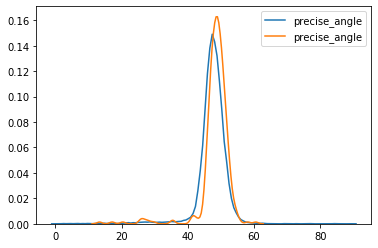

In [452]:
sns.kdeplot(df_shots['precise_angle'])
sns.kdeplot(df_shots.query('player_id==201939')['precise_angle'])
#sns.kdeplot(df_shots.query('player_id==203709')['precise_angle'])

### Angle and distance to basket

In [243]:
def release_d_basket(row):
    x=row['x_shooter']
    y=row['y_shooter']
    x_ball=row['x_ball']
    
    if x_ball[-1]>94//2:
        basket_pos=[94-5.25,25]
    else :
        basket_pos=[5.25,25]
    return(np.sqrt((x-basket_pos[0])**2+(y-basket_pos[1])**2))

#df_traj['release_d_basket']=df_traj.apply(release_d_basket,axis=1)
df_shots['release_d_basket']=df_shots.apply(release_d_basket,axis=1)

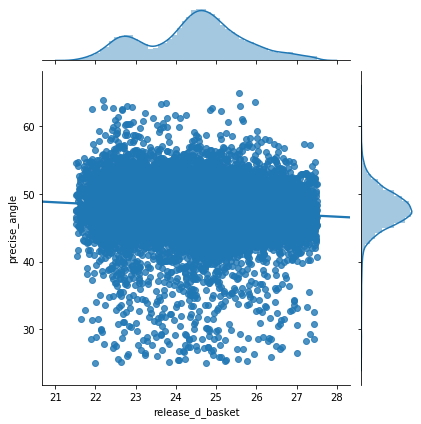

In [384]:
g=sns.jointplot(x='release_d_basket',y='precise_angle', data=df_shots.query('25<precise_angle<65 and release_d_basket<27.5'),kind='reg')

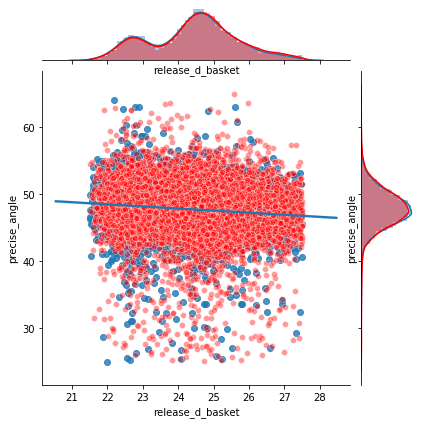

In [383]:
g=sns.jointplot(x='release_d_basket',y='precise_angle', data=df_shots[df_shots['Shot result']==1].query('25<precise_angle<65 and release_d_basket<27.5'),kind='reg')
g.x=df_shots[df_shots['Shot result']==0].query('25<precise_angle<65 and release_d_basket<27.5')['release_d_basket']
g.y=df_shots[df_shots['Shot result']==0].query('25<precise_angle<65 and release_d_basket<27.5')['precise_angle']
g.plot_joint(sns.scatterplot,color='red',alpha=0.4)
g.plot_marginals(sns.distplot,color='red')

In [386]:
def release_time(row):
    z_ball=row['z_ball']
    d_basket=row['d_basket']
    angle=row['angle']
    Time=row['Time']
    
    release_time=z_ball.index(max(z_ball))
    release_time-=1
    while release_time>0 and z_ball[release_time]>8.2 and (30<angle[release_time] or angle[release_time]<70):
        release_time-=1
        
    if release_time==0:
        return 0.
    
    else :
        release_time+=1
        return(Time[release_time])
    
df_shots['release_time']=df_shots.apply(release_time,axis=1)

In [387]:
def d_closest_def_release(row):
    z_ball=row['z_ball']
    d_basket=row['d_basket']
    release_time=row['release_time']
    Time=row['Time']
    
    ind=Time.index(release_time)
    return(row['D'][ind])

df_shots['d_closest_release']=df_shots.apply(d_closest_def_release,axis=1)

In [455]:
def new_time_to_shoot(row):
    release_time=row['release_time']
    TTS=row['Time_to_shoot']
    return(TTS-release_time)

def new_time(row):
    release_time=row['release_time']
    Time=row['Time']
    return(list(np.array(Time)-release_time))


df_shots['Time_to_shoot']=df_shots.apply(new_time_to_shoot,axis=1)
df_shots['Time']=df_shots.apply(new_time,axis=1)
    

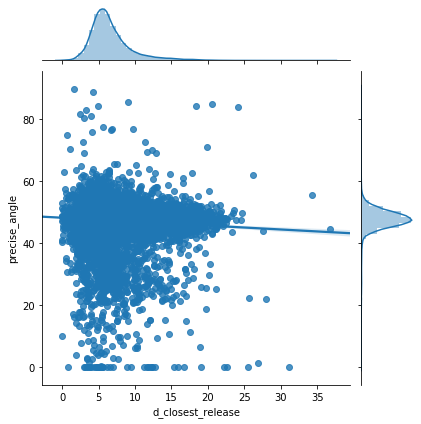

In [388]:
g=sns.jointplot(x='d_closest_release',y='precise_angle', data=df_shots,kind='reg')

player_id        222698.068163
precise_angle        47.374206
dtype: float64
R^2 :  8.954918032853495e-05


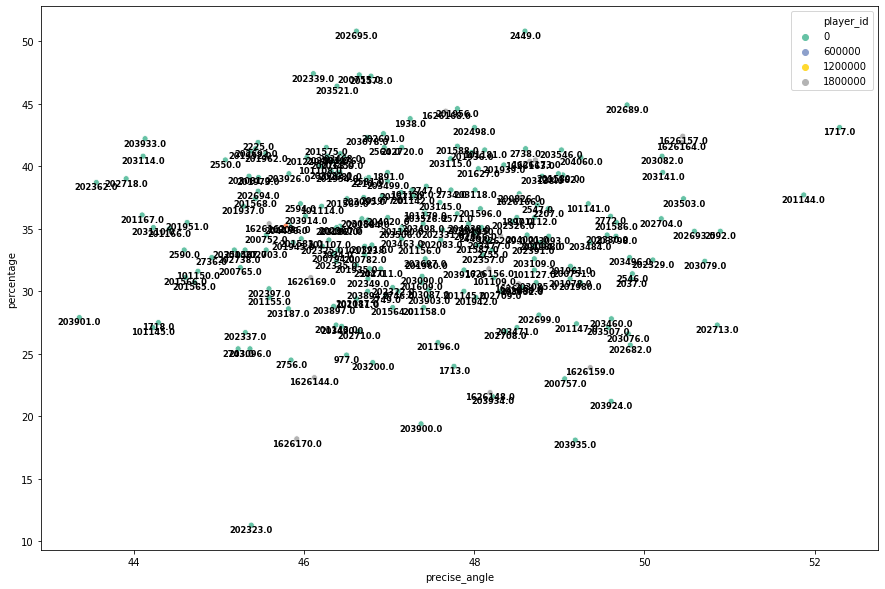

In [434]:
from scipy import stats
fig,ax=plt.subplots(1,1,figsize=(15,10))

players=df_stats.query('total>30').index
df_shots_mean=df_shots.query('player_id in @players')[['player_id','precise_angle']].groupby('player_id').mean()
print(df_shots.query('player_id in @players')[['player_id','precise_angle']].mean())
df_plot_shots=df_shots_mean.join(df_stats.query('total>30'))
df_plot_shots['player_id']=df_shots_mean.index
#df_shots_mean.plot(x='d_reception',y='Time_to_shoot',kind='scatter',ax=ax)
p=sns.scatterplot(x='precise_angle',y='percentage',palette="Set2", data=df_plot_shots,hue='player_id',ax=ax)
for line in range(df_plot_shots.shape[0]):
    p.text(df_plot_shots.iloc[line]['precise_angle'], df_plot_shots.iloc[line]['percentage'], df_plot_shots.iloc[line]['player_id'], horizontalalignment='center', verticalalignment='top',size='small', color='black', weight='semibold')
    
slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot_shots['precise_angle'], df_plot_shots['percentage'])
print('R^2 : ',r_value**2)

player_id            222698.068163
precise_angle            47.374206
d_closest_release         6.630773
dtype: float64
R^2 :  0.0014610634071090013


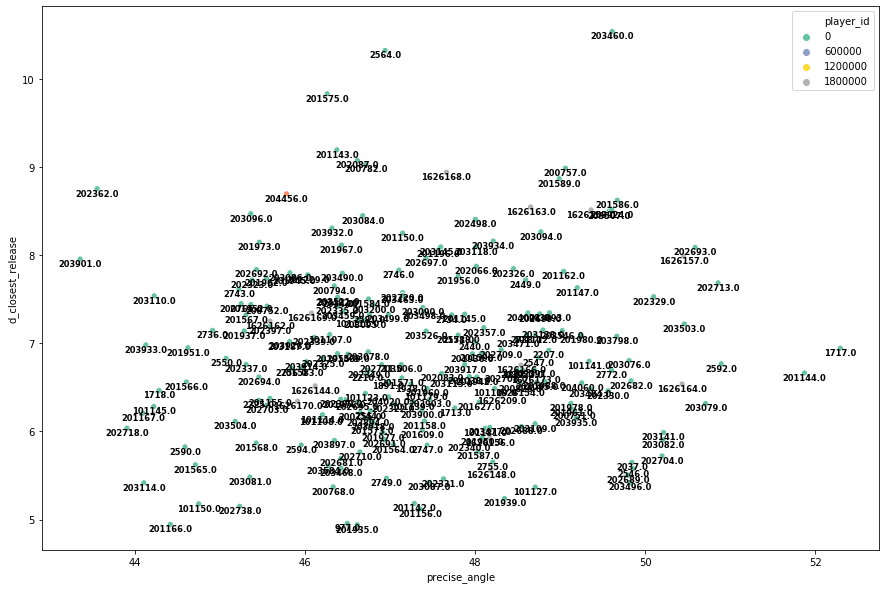

In [436]:
fig,ax=plt.subplots(1,1,figsize=(15,10))

players=df_stats.query('total>30').index
df_shots_mean=df_shots.query('player_id in @players')[['player_id','precise_angle','d_closest_release']].groupby('player_id').mean()
print(df_shots.query('player_id in @players')[['player_id','precise_angle','d_closest_release']].mean())
df_plot_shots=df_shots_mean.join(df_stats.query('total>30'))
df_plot_shots['player_id']=df_shots_mean.index
#df_shots_mean.plot(x='d_reception',y='Time_to_shoot',kind='scatter',ax=ax)
p=sns.scatterplot(x='precise_angle',y='d_closest_release',palette="Set2", data=df_plot_shots,hue='player_id',ax=ax)
for line in range(df_plot_shots.shape[0]):
    p.text(df_plot_shots.iloc[line]['precise_angle'], df_plot_shots.iloc[line]['d_closest_release'], df_plot_shots.iloc[line]['player_id'], horizontalalignment='center', verticalalignment='top',size='small', color='black', weight='semibold')
    
slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot_shots['precise_angle'], df_plot_shots['d_closest_release'])
print('R^2 : ',r_value**2)

(40, 60)

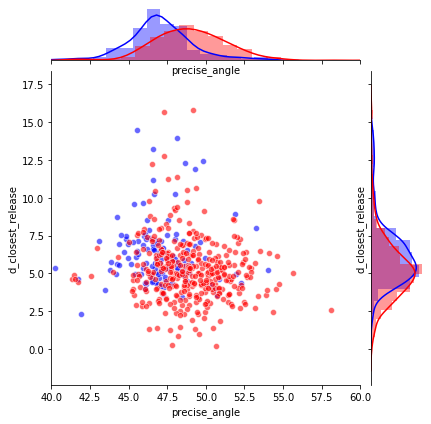

In [439]:
g = sns.JointGrid(x='precise_angle',y='d_closest_release', data=df_shots.query('player_id==202695'))
g.plot_joint(sns.scatterplot,color='blue',alpha=0.6)
g.plot_marginals(sns.distplot,color='blue')
g.x=df_shots.query('player_id==201939')['precise_angle']
g.y=df_shots.query('player_id==201939')['d_closest_release']
g.plot_joint(sns.scatterplot,color='red',alpha=0.6)
g.plot_marginals(sns.distplot,color='red')
g.ax_joint.set_xlim((40,60))

## Classify shots
----

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

## *Free space* and 3P performance
------

We want to quantify the following intuition : "the more free a shooter is, the more efficient he is". To do so, we evaluate 3-point efficiency function of the distance (and time) within the opponent defender is. The code is available in python-file/statistics.py.

![](images/efficiency_inferior_d_bis.png)
*Shot efficiency as a function of maximum available space $\delta_{space}^*$ at the release-time of the ball. If the closest defender is within 4 feet, the shooting percentage is 26,3\%, while it goes to 33,6\% if he is within 8 feet.*

![](images/efficiency_inferior_t_bis.png)
*Shot efficiency as a function of maximum available time $\delta_{time}^*$ (free space) at the release of the ball. Around $t=0.5s$ a significant change in behaviour is observed.*


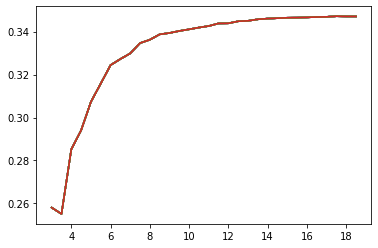

In [450]:
d_abs=[0.5*(i+6) for i in range(32)]
inferior_values=[]
for d in d_abs:
    m=df_shots.query('d_closest_release<@d').groupby('Shot result').count().loc[0]
    s=df_shots.query('d_closest_release<@d').groupby('Shot result').count().loc[1]
    inferior_values.append(s/(s+m))
    
plt.plot(d_abs,inferior_values)

##### Classifying players
---

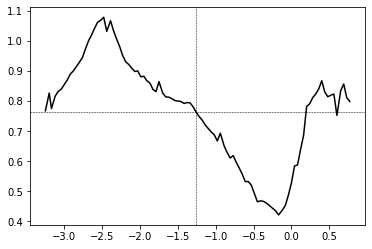

In [208]:
plt.plot(df_shots.iloc[30]['Time'],df_shots.iloc[30]['T'],'k-')
plt.axhline(df_shots.iloc[30]['t_reception'], color='black',linestyle="dashed",lw=0.5)
plt.axvline(df_shots.iloc[30]['Time_to_shoot'][0], color='black',linestyle="dashed",lw=0.5)

In [108]:
df_stats.loc[201587]

total             181.0
success            61.0
miss              120.0
percentage         33.7
match_played       35.0
total_cas         127.0
success_cas        46.0
miss_cas           81.0
percentage_cas     36.2
Name: 201587, dtype: float64

In [104]:
id_inf_25=df_stats.query('total>50 and percentage<25').index
id_25_30=df_stats.query('total>50 and 25<=percentage<30').index
id_30_35=df_stats.query('total>50 and 30<=percentage<35').index
id_35_40=df_stats.query('total>50 and 35<=percentage<40').index
id_sup_40=df_stats.query('total>50 and percentage>=40').index

def players_accuracy(row):
    if row['player_id'] in id_inf_25 :
        return('inf_25')
    if row['player_id'] in id_25_30 :
        return('25_30')
    if row['player_id'] in id_30_35 :
        return('30_35')
    if row['player_id'] in id_35_40 :
        return('35_40')
    if row['player_id'] in id_sup_40 :
        return('sup_40')
    return ('not enough shots')

df_plot_players=df.copy()
df_plot_players['player_accuracy']=df.apply(players_accuracy,axis=1)

In [113]:
df_plot_players=df_plot_players.query('player_accuracy!="not enough shots"')

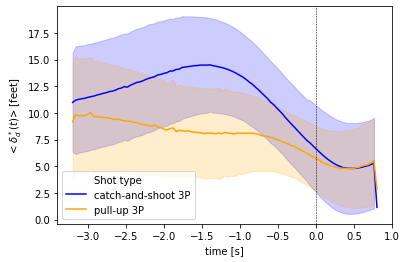

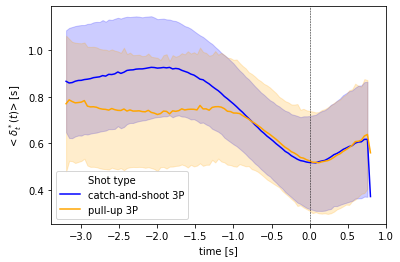

<Figure size 432x288 with 0 Axes>

In [121]:
averaged_evolution(df_plot_players.query('player_accuracy=="inf_25"'),hue='Shot type',palette=['blue','orange'],fontsize='medium',sd='sd')

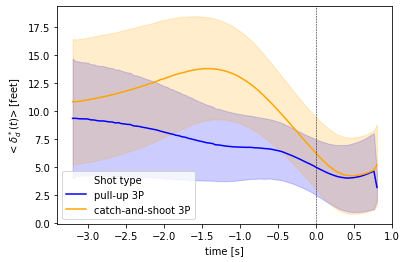

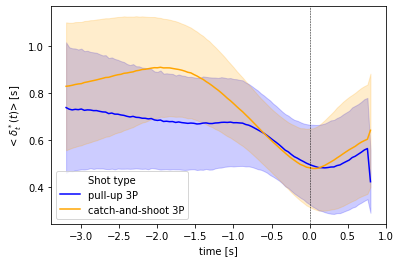

<Figure size 432x288 with 0 Axes>

In [122]:
averaged_evolution(df_plot_players.query('player_accuracy=="25_30"'),hue='Shot type',palette=['blue','orange'],fontsize='medium',sd='sd')

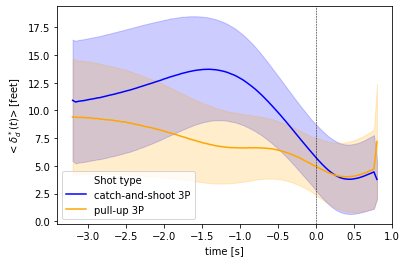

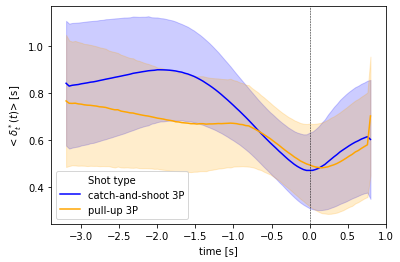

<Figure size 432x288 with 0 Axes>

In [123]:
averaged_evolution(df_plot_players.query('player_accuracy=="30_35"'),hue='Shot type',palette=['blue','orange'],fontsize='medium',sd='sd')

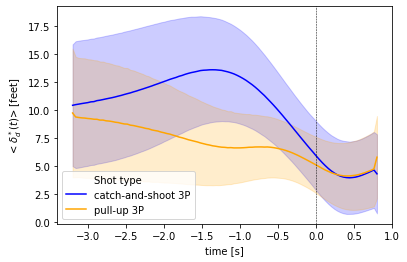

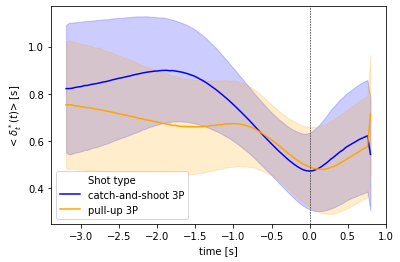

<Figure size 432x288 with 0 Axes>

In [124]:
averaged_evolution(df_plot_players.query('player_accuracy=="35_40"'),hue='Shot type',palette=['blue','orange'],fontsize='medium',sd='sd')

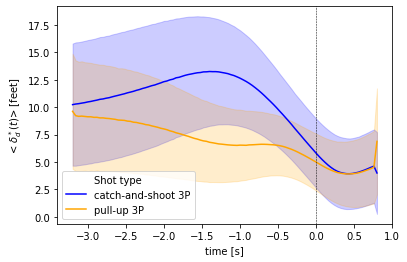

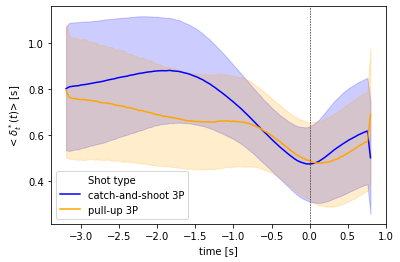

<Figure size 432x288 with 0 Axes>

In [125]:
averaged_evolution(df_plot_players.query('player_accuracy=="sup_40"'),hue='Shot type',palette=['blue','orange'],fontsize='medium',sd='sd')

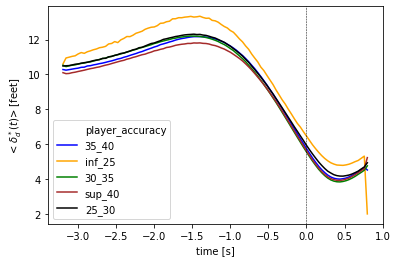

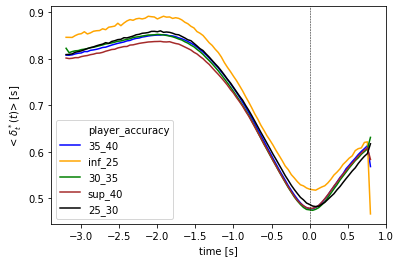

<Figure size 432x288 with 0 Axes>

In [119]:
averaged_evolution(df_plot_players,hue='player_accuracy',palette=['blue','orange','green','brown','black'],fontsize='medium')

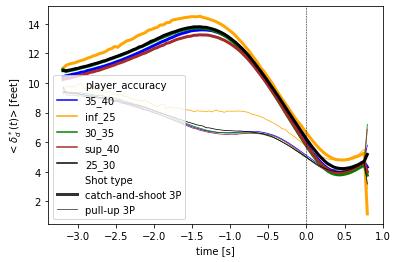

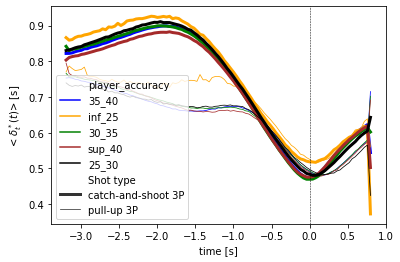

<Figure size 432x288 with 0 Axes>

In [118]:
averaged_evolution(df_plot_players,hue='player_accuracy',palette=['blue','orange','green','brown','black'],fontsize='medium',size='Shot type')

In [23]:
def clock(c):
    return(str(c//60)+'m '+str(c%60))

In [141]:
MATCH_ID=dico['MATCH_ID']

In [150]:
print(len(MATCH_ID)/len(dico['D_CLOSEST_DEF']))

10.526864672515238


In [123]:
df_shots.columns

Index(['D', 'T', 'Time', 'Time_to_shoot', 'Shot result', 'player_id', 'x_ball',
       'y_ball', 'z_ball', 'x_shooter', 'y_shooter', 'quarter', 'clock',
       'Match_id', 'shot_id', 'Shot_type', 'd_reception', 't_reception'],
      dtype='object')